In [162]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cvxpy as cp

# Plot options

In [3]:
sns.set_style("whitegrid")

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# 1. Exponencial smoothing

Assume that we have a reasonably stable demand. The discrete nature of sampling methodology makes the curve uglier, even if it is stable. We solve this issue by smoothing the demand curve using exp() function: $$F_t = \alpha D_{t-1} + (1-\alpha) F_{t-1}$$

where $\alpha$ says: How much weight to give the past info.

NOTE:

* Big $\alpha$: Naive forecasting (Reactive).
* Small $\alpha$: Cumulative mean (Stable).

Usually $\alpha \in (0,1)$.

Question: How to pick $\alpha$?.

Answer: Use some optimization strategy (Change $\alpha$ according to accuracy).

In order to compute $F_t$, the following recursion is required. First (Not necessarily $D_0$):
$$ F_1 = D_0 $$

Then, $$F_2 = \alpha D_1 + (1 - \alpha) F_1 = \alpha D_1 + (1-\alpha) D_0$$

In similar manner, $$F_3 = \alpha D_2 + (1 - \alpha)  F_2 = \alpha D_2 + (1 - \alpha) (\alpha D_1 + (1 - \alpha) F_1) =  \alpha D_2 + (1 - \alpha) (\alpha D_1 + (1 - \alpha) D_0)) $$

Then, clearly: $$F_t = \alpha \sum_{t = 1}^T (1-\alpha)^{t-1} D_{t-1}$$

Let's call the data

In [ ]:
demand = pd.read_csv("Forecast-Example-Data.csv")

Now, let's do ES:

In [279]:
alpha = 0.2

In [280]:
ES_forecast = [20]
for t in range(demand.shape[0]):
    ES_forecast.append(alpha*demand["Demand"].values[t] + (1-alpha)*ES_forecast[t])
ES_forecast = np.asarray(ES_forecast).round(1)

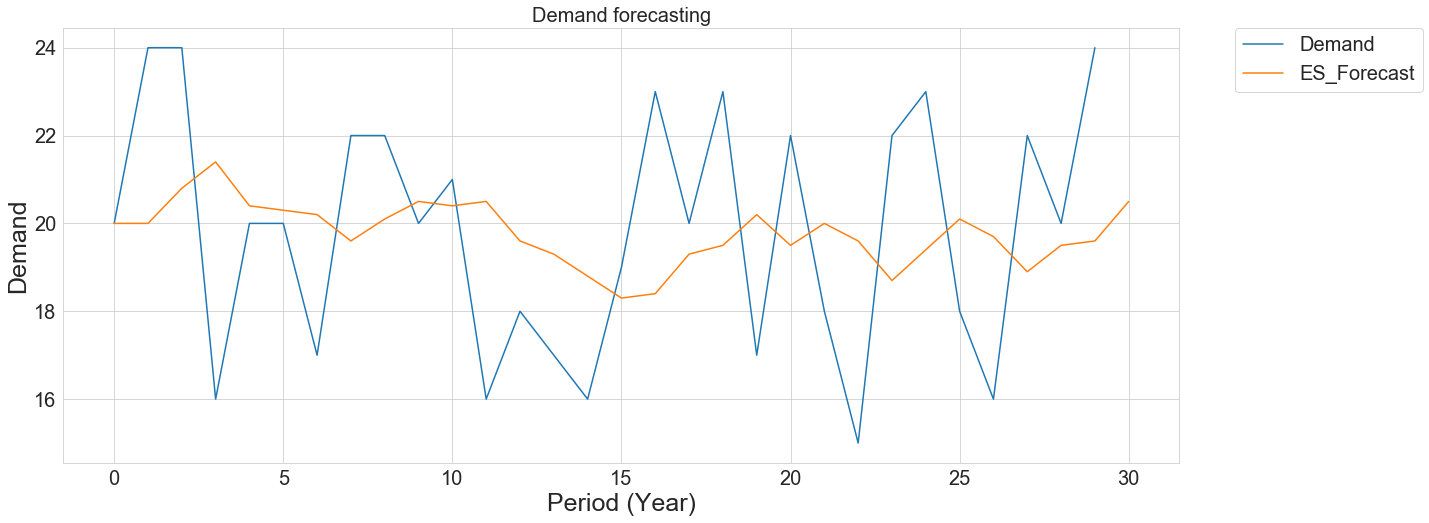

In [281]:
plt.figure(figsize=(20, 8))
demand_plot = plt.plot(demand, label = 'Demand')
forecast_plot = plt.plot(ES_forecast, label = 'ES_Forecast')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Period (Year)")
plt.ylabel("Demand")
plt.title("Demand forecasting")
plt.show()

In [236]:
print("MSE = ", (np.linalg.norm((demand.Demand.values[1:] - ES_forecast[1:-1]), 2)**2)/demand.shape[0])

MSE =  7.411


## 1.1. Choosing the optimal alpha

Notice that calculating alpha for this problem:
$$\min_{\alpha \in [0,1]} \{ \|(D_t)_{t \in [30]} - (F_t)_{t \in [30]} \|_2^2 : F_t = \alpha D_{t-1} + (1-\alpha) F_{t-1}, F_t \geq 0 \}$$

is a NON-CONVEX optimization problem, in terms of $\alpha$. THIS PROBLEM IS DIFFICULT... BUT STILL, it is one variable problem. We can just do the following:

In [290]:
lb = -0.115
ub = 1
ref = 10000

MSE = []
for a in np.linspace(lb, ub, ref):
    ES_forecast = [20]
    for t in range(demand.shape[0]):
        ES_forecast.append(a*demand["Demand"].values[t] + (1-a)*ES_forecast[t])
    ES_forecast = np.asarray(ES_forecast).round(1)
    MSE.append((np.linalg.norm((demand.Demand.values[1:] - ES_forecast[1:-1]), 2)**2)/demand.shape[0])
MSE = np.asarray(MSE)

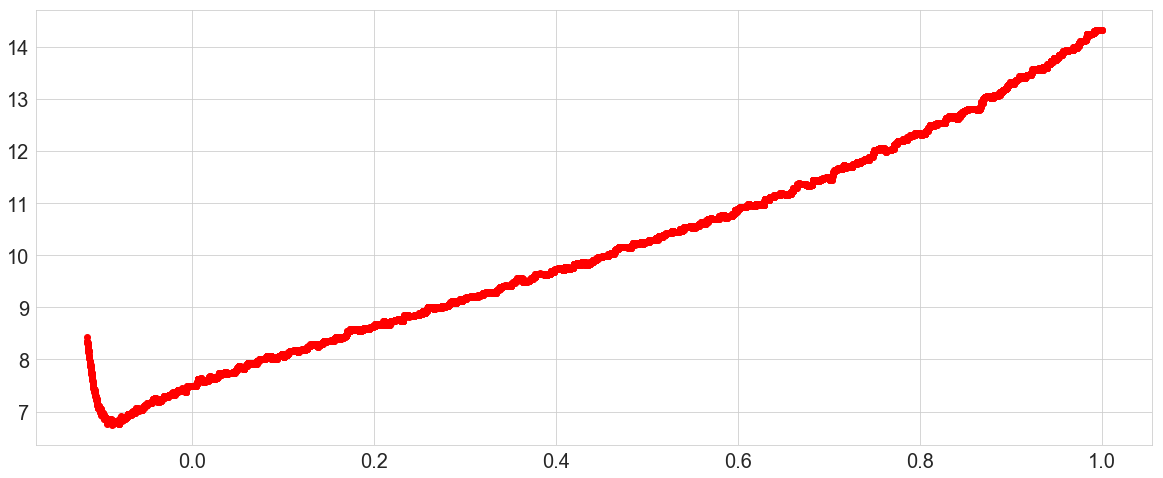

In [291]:
plt.figure(figsize=(20,8))
plt.plot(np.linspace(lb, ub, ref), MSE, 'ro')
plt.show()

Given discretization, we pick the best point (10000 pts):

In [292]:
opt_alpha = np.linspace(lb, ub, ref)[np.argmin(MSE)]
print("The optimal alpha value is: ", opt_alpha)

The optimal alpha value is:  -0.08745674567456746


The problem is clearly non-convex. Loot at this:

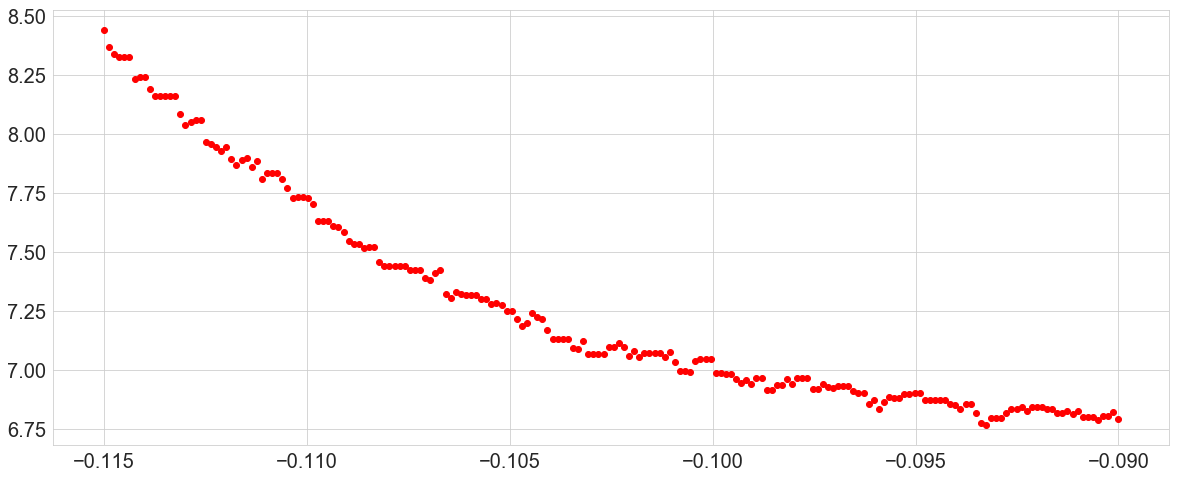

In [295]:
lb = -0.115
ub = -0.09
ref = 200

MSE = []
for a in np.linspace(lb, ub, ref):
    ES_forecast = [20]
    for t in range(demand.shape[0]):
        ES_forecast.append(a*demand["Demand"].values[t] + (1-a)*ES_forecast[t])
    ES_forecast = np.asarray(ES_forecast).round(1)
    MSE.append((np.linalg.norm((demand.Demand.values[1:] - ES_forecast[1:-1]), 2)**2)/demand.shape[0])
MSE = np.asarray(MSE)

plt.figure(figsize=(20,8))
plt.plot(np.linspace(lb, ub, ref), MSE, 'ro')
plt.show()

Anyway, using the given alpha, we have:

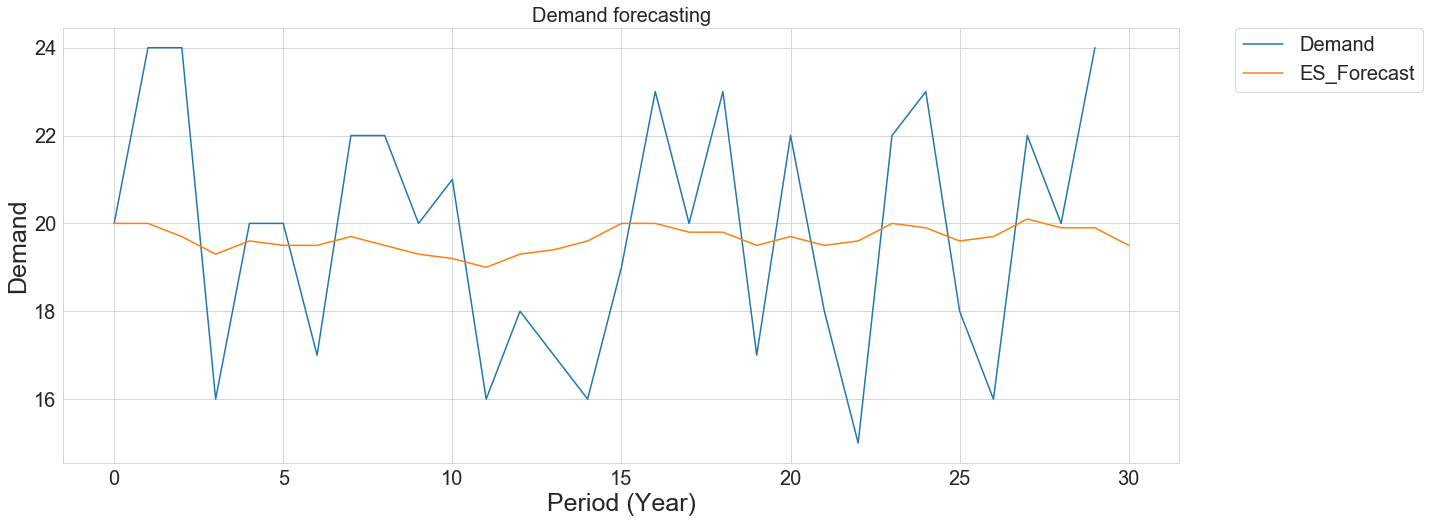

In [296]:
ES_forecast = [20]
for t in range(demand.shape[0]):
    ES_forecast.append(opt_alpha*demand["Demand"].values[t] + (1-opt_alpha)*ES_forecast[t])
ES_forecast = np.asarray(ES_forecast).round(1)

plt.figure(figsize=(20, 8))
demand_plot = plt.plot(demand, label = 'Demand')
forecast_plot = plt.plot(ES_forecast, label = 'ES_Forecast')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Period (Year)")
plt.ylabel("Demand")
plt.title("Demand forecasting")
plt.show()